# Profile of `maze_dataset` Dumping and Loading

In [1]:
# import copy
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytest
import timeit
from typing import Callable

# from maze_dataset.constants import CoordArray
# from maze_dataset.dataset.dataset import (
#     register_dataset_filter,
#     register_filter_namespace_for_dataset,
# )
from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
    # register_maze_filter,
)
# from maze_dataset.maze import SolvedMaze
# from maze_dataset.utils import bool_array_from_string
# from maze_dataset.plotting import plot_dataset_mazes, print_dataset_mazes
from maze_dataset.generation.generators import GENERATORS_MAP

# from zanj import ZANJ

## Generate Datasets


In [2]:
cfgs = [MazeDatasetConfig(name="test", grid_n=grid_n, n_mazes=n_mazes, maze_ctor=maze_ctor, maze_ctor_kwargs=maze_ctor_kwargs, serialize_minimal_threshold=srz_threshold) 
        for grid_n, n_mazes, maze_ctor, maze_ctor_kwargs, srz_threshold in [
                (3, 2, GENERATORS_MAP['gen_dfs'], {}, None), 
                (5, 10, GENERATORS_MAP['gen_dfs'], dict(do_forks=False), None), 
                (5, 10, GENERATORS_MAP['gen_dfs'], {}, None), 
                (5, 100, GENERATORS_MAP['gen_dfs'], {}, None), 
                # (5, 1000, GENERATORS_MAP['gen_dfs'], {}),
                # (5, 10000, GENERATORS_MAP['gen_dfs'], {}), 
                # (10, 1000, GENERATORS_MAP['gen_dfs'], {}),
                ]]
datasets = [MazeDataset.generate(cfg) for cfg in cfgs]

## Profile

In [3]:
def quicktimeit(
    cmd: Callable[[], any]|str, 
    setup:str = lambda: None, 
    repeats:int = 5, 
    total_runtime:float = 1.0, 
    namespace:dict[str, any]|None=None, 
    get_return=False
    ):
    """
    Wrapper for `timeit` to get the fastest run of a callable.
    `total_runtime`: Indication of the rough total wall clock time in seconds the call to `quicktimeit` should take.
    If a single execution of `cmd` takes longer than `total_runtime/repeats`, then `total_rutime` may still be greatly exceeded.
    `namespace`: Passed to `timeit.Timer` constructor. 
    If `cmd` or `setup` use local or global variables, they must be passed here. See `timeit` documentation for details.
    `get_return`: Whether to pass the value returned from `cmd`. If True, the return value will be appended in a tuple with execution time.
    This is for speed and convenience so that `cmd` doesn't need to be run again in the calling scope if the return values are needed.
    `get_return` is only supported
    """
    timer = timeit.Timer(cmd, setup, globals=namespace)
    n, _ = timer.autorange()
    num = max(round(n/(0.2/(total_runtime/repeats))),1)  # 0.2s is the default time per repeat used in `timeit.autorange`.
    min_time = min([t/num for t in timer.repeat(repeats, num)]) # timeit documentation recommends using the fastest run, ignoring 
    if get_return:
        if isinstance(cmd, str):
            raise TypeError(f'`cmd` must be a callable if `get_return=True`, not type {type(cmd)}.')
            # Support for `str` types could be added if it were allowable to use the `exec` command.
        return min_time, cmd()
    return min_time


# b = quicktimeit(lambda: datasets[0].serialize(), get_return=True)
# foo = ' Foo bar '
# b = quicktimeit(lambda: foo.split('o'), total_runtime=2, repeats=5, namespace=None, get_return=True)
# b

In [4]:
columns=['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds = pd.DataFrame(np.zeros([len(cfgs), len(columns)]), columns=columns)
speeds.grid_n = [c.grid_n for c in cfgs]
speeds.n_mazes = [c.n_mazes for c in cfgs]

In [11]:
for i, d in enumerate(datasets):
    if i not in range(0,3): continue
    print(d.cfg)
    d.cfg.serialize_minimal_threshold = None
    speeds.loc[i, 'serialize']        , s    = quicktimeit(d.serialize, get_return=True)
    speeds.loc[i, 'serialize_minimal'], smin = quicktimeit(d.serialize_minimal, get_return=True)
    speeds.loc[i, 'load']                    = quicktimeit(lambda: MazeDataset.load(s))
    speeds.loc[i, 'load_minimal']            = quicktimeit(lambda: MazeDataset.load(smin))
    p = Path(os.getcwd())/(d.cfg.to_fname()+'.zanj')
    p_min = Path(os.getcwd())/(d.cfg.to_fname()+'_min.zanj')
    speeds.loc[i, 'save']                    = quicktimeit(lambda: d.save(file_path=p))
    speeds.loc[i, 'read'], rt                = quicktimeit(lambda: MazeDataset.read(file_path=p), get_return=True)
    d.cfg.serialize_minimal_threshold = 1
    speeds.loc[i, 'save_minimal']            = quicktimeit(lambda: d.save(file_path=p_min))
    speeds.loc[i, 'read_minimal'], rt_min    = quicktimeit(lambda: MazeDataset.read(file_path=p_min), get_return=True)
    d.cfg.serialize_minimal_threshold = None
    # rt
    # !rm {p} {p_min}
    

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_

: 

In [ ]:
# Delete all the zanj files
for c in cfgs:
    p = Path(os.getcwd())/(d.cfg.to_fname()+'.zanj')
    p_min = Path(os.getcwd())/(d.cfg.to_fname()+'_min.zanj')
    !rm {p} {p_min}
    

In [17]:
# zanj = ZANJ()
# d = datasets[0]
# s=d.serialize()
# p = Path(os.getcwd())/(d.cfg.to_fname()+'.zanj')
# quicktimeit(lambda: zanj.save(s, file_path=p), namespace=locals())
# quicktimeit(lambda: zanj.read(file_path=p), namespace=locals())
# i, rt.mazes[0].connection_list, d.mazes[0].connection_list
1e10

10000000000.0

# Profiling Results

In [15]:
speeds

,grid_n,n_mazes,serialize,serialize_minimal,load,load_minimal,save,save_minimal,read,read_minimal
0,3,2,0.007041,0.022704,0.023653,0.022989,0.100838,0.100549,0.027682,0.027255
1,5,10,0.007006,0.027024,0.027165,0.022921,0.114103,0.117638,0.037910,0.037339
2,5,10,0.007030,0.025051,0.027950,0.023239,0.129374,0.121284,0.048985,0.047427
3,5,100,0.008541,0.057446,0.066536,0.022354,0.352412,0.360882,0.249871,0.228286
4,5,1000,0.024553,0.350254,0.472939,0.068070,1.009522,1.007566,2.176631,2.181613
5,5,10000,0.176987,3.285273,4.654142,0.578686,9.393300,9.161077,21.878630,21.535251
6,10,1000,0.023421,0.363099,0.466222,0.068891,2.493533,2.503989,6.862977,7.291965


Comparing lines 4 and 6, it appears that the `grid_n` has little effect on runtimes. `serialize` and `load` runtimes scale roughly linearly with `n_mazes`.

Given that `grid_n` doesn't confound the results, the plots below show data from `speeds.loc[2:5,:]` to compare the speed of analogous procedures vs `n_mazes`. 

Text(0, 0.5, 'Runtime [sec]')

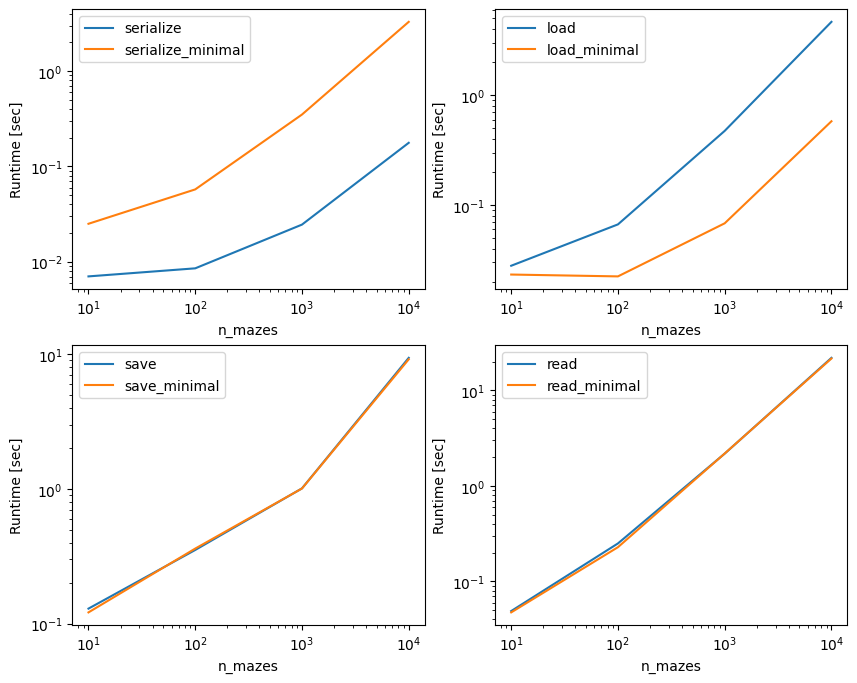

In [16]:
fig = plt.figure(figsize=(10,8))
fig.subplots(2,2)
ax = fig.axes[0]
speeds.loc[2:5, ['n_mazes', 'serialize', 'serialize_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[1]
speeds.loc[2:5, ['n_mazes', 'load', 'load_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[2]
speeds.loc[2:5, ['n_mazes', 'save', 'save_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[3]
speeds.loc[2:5, ['n_mazes', 'read', 'read_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')